In [30]:
%cd "/Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025"


/Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025


In [3]:
pip install yfinance pandas numpy pyarrow


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 16.3 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 17.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.7 MB/s eta 0:00:00a 0:00:01
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15636 sha256=ad1cf6ea58d6f798e5d3b83673a1465e0ec1c3f28cb25df1ef6c96675da370f0
  Stored in directory: /Users/jacobhahn/Library/Caches/pip/wheels/1e/df/0f/e2bbb22d689b30c681feb5410ab64a2523437b34c8ecfc6476
  Created wheel for peewee: filename=peewee-3.18.3-cp313-cp313-macosx_15_0_arm64.whl size=272304 sha256=662167fe40d9afc991c7d5a3f348a311434447373f840cc01014a69c287a966a
  Stored i

In [17]:
import sys
!{sys.executable} -m pip install --upgrade pip


  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.1 MB/s eta 0:00:00


In [18]:
import os
os.getcwd()


'/Users/jacobhahn/QUANT PROJECT WINTER 2025'

In [20]:
%%writefile download_etf_data.py
from __future__ import annotations

import os
from dataclasses import dataclass
from typing import List, Tuple

import numpy as np
import pandas as pd
import yfinance as yf


@dataclass
class Config:
    start_date: str = "2014-01-01"
    end_date: str = "2025-12-19"
    interval: str = "1d"

    # Ticker filtering thresholds:
    min_nonnull_fraction: float = 0.95   # keep tickers with >=95% non-missing prices
    max_start_lag_days: int = 90         # must start within ~90 trading days of start_date
    require_last_within_days: int = 10   # must end within ~10 trading days of end_date

    # Date filtering threshold:
    drop_any_missing_dates: bool = True  # drop any dates where any kept ticker is missing

    out_dir: str = "data_processed"


ETFS_50: List[str] = [
    "SPY","IVV","VTI","QQQ","DIA","IWM","IJR","MDY",
    "IWF","IWD","VUG","VTV","MTUM","QUAL","USMV","VLUE","DVY","VYM",
    "XLK","XLF","XLE","XLV","XLY","XLP","XLI","XLU","XLB","VNQ",
    "VXUS","VEA","EFA","VWO","EEM","IEMG","EWJ","EWU","EWG","FXI",
    "BND","SHY","IEF","TLT","TIP","LQD","HYG","EMB","BKLN","MUB",
    "GLD",
]


def download_prices(tickers: List[str], cfg: Config) -> pd.DataFrame:
    df = yf.download(
        tickers=tickers,
        start=cfg.start_date,
        end=cfg.end_date,
        interval=cfg.interval,
        auto_adjust=False,
        actions=False,
        group_by="column",
        threads=True,
        progress=False,
    )

    if isinstance(df.columns, pd.MultiIndex):
        if "Adj Close" in df.columns.get_level_values(0):
            prices = df["Adj Close"].copy()
        elif "Close" in df.columns.get_level_values(0):
            # fallback if Adj Close missing
            prices = df["Close"].copy()
        else:
            raise RuntimeError("Could not find Adj Close or Close in yfinance response.")
    else:
        # single ticker case
        col = "Adj Close" if "Adj Close" in df.columns else "Close"
        prices = df[col].to_frame(name=tickers[0])

    prices.index = pd.to_datetime(prices.index)
    prices.sort_index(inplace=True)
    prices = prices.replace([np.inf, -np.inf], np.nan)
    return prices


def quality_report(prices: pd.DataFrame) -> pd.DataFrame:
    total_days = len(prices.index)
    rows = []
    for t in prices.columns:
        s = prices[t]
        rows.append({
            "ticker": t,
            "first_valid_date": s.first_valid_index(),
            "last_valid_date": s.last_valid_index(),
            "nonnull_days": int(s.notna().sum()),
            "total_days": int(total_days),
            "nonnull_fraction": float(s.notna().sum() / total_days) if total_days else 0.0,
        })
    return pd.DataFrame(rows).sort_values(["nonnull_fraction", "ticker"], ascending=[False, True])


def filter_tickers(prices: pd.DataFrame, cfg: Config) -> Tuple[pd.DataFrame, pd.DataFrame, List[str]]:
    rep = quality_report(prices)
    start = pd.to_datetime(cfg.start_date)
    end = pd.to_datetime(cfg.end_date)

    # crude calendar-day cushions to approximate trading days
    start_ok = rep["first_valid_date"].notna() & (rep["first_valid_date"] <= start + pd.Timedelta(days=cfg.max_start_lag_days * 2))
    end_ok = rep["last_valid_date"].notna() & (rep["last_valid_date"] >= end - pd.Timedelta(days=cfg.require_last_within_days * 3))
    frac_ok = rep["nonnull_fraction"] >= cfg.min_nonnull_fraction

    keep = rep.loc[start_ok & end_ok & frac_ok, "ticker"].tolist()
    dropped = sorted(set(prices.columns) - set(keep))

    return prices[keep].copy(), rep, dropped


def log_returns(prices: pd.DataFrame) -> pd.DataFrame:
    r = np.log(prices / prices.shift(1))
    return r.dropna(how="all")


def main():
    cfg = Config()
    os.makedirs(cfg.out_dir, exist_ok=True)

    print(f"Downloading {len(ETFS_50)} ETFs from {cfg.start_date} to {cfg.end_date}...")
    prices = download_prices(ETFS_50, cfg)

    filtered_prices, rep, dropped = filter_tickers(prices, cfg)

    print("\n=== Ticker filtering ===")
    print(f"Downloaded columns: {prices.shape[1]}")
    print(f"Kept tickers: {filtered_prices.shape[1]}")
    if dropped:
        print(f"Dropped ({len(dropped)}): {', '.join(dropped)}")

    if cfg.drop_any_missing_dates:
        before = len(filtered_prices)
        filtered_prices = filtered_prices.dropna(how="any")
        after = len(filtered_prices)
        print(f"\nDropped dates to make complete panel: {before - after} (kept {after} dates)")

    rets = log_returns(filtered_prices)

    prices_path = os.path.join(cfg.out_dir, "prices_adjusted.csv")
    rets_path = os.path.join(cfg.out_dir, "returns_log.csv")
    rep_path = os.path.join(cfg.out_dir, "data_quality_report.csv")

    filtered_prices.to_csv(prices_path)
    rets.to_csv(rets_path)
    rep.to_csv(rep_path, index=False)

    print("\n=== Saved ===")
    print(prices_path)
    print(rets_path)
    print(rep_path)

    print("\nPrices head:")
    print(filtered_prices.head())
    print("\nReturns head:")
    print(rets.head())


if __name__ == "__main__":
    main()


Overwriting download_etf_data.py


In [21]:
!ls


DataCollection.ipynb download_etf_data.py


In [24]:
import sys
!{sys.executable} -m pip install pandas numpy yfinance


  Using cached yfinance-0.2.66-py2.py3-none-any.whl.metadata (6.0 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached frozendict-2.4.7-py3-none-any.whl.metadata (23 kB)
  Using cached beautifulsoup4-4.14.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached curl_cffi-0.14.0-cp39-abi3-macosx_14_0_arm64.whl.metadata (15 kB)
  Using cached protobuf-6.33.2-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
  Using cached cffi-2.0.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (2.6 kB)
  Using cached charset_normalizer-3.4.4-cp313-cp313-macosx_10_13_universal2.whl.metadata (37 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
Using cached yfinance-0.2.66-py2.py3-none-any.whl (123 kB)
Using cached beautifulsoup4-4.14.3-py3-none-any.whl (107 kB)
Using cached curl_cffi-0.14.0-cp39-abi3-macosx_14_0_arm64.whl (3.1 MB)
Using cached cffi-2.0.0-cp313-cp313-macosx_11_0_arm64.whl (181 kB)
Using cached frozendict-2.4.7-py3-none-any.whl (16 kB)
Using ca

In [25]:
import sys
!{sys.executable} download_etf_data.py



=== Ticker filtering ===
Downloaded columns: 49
Kept tickers: 49

Dropped dates to make complete panel: 1 (kept 3009 dates)

=== Saved ===
data_processed/prices_adjusted.csv
data_processed/returns_log.csv
data_processed/data_quality_report.csv

Prices head:
Ticker           BKLN        BND         DIA  ...        IWD        IWF        LQD
Date                                          ...                                 
2014-01-02  13.589220  56.922382  128.590744  ...  71.680260  75.878357  75.605247
2014-01-03  13.600149  56.929523  128.810150  ...  71.833946  75.780388  75.717636
2014-01-06  13.583770  56.979244  128.418442  ...  71.741714  75.326195  75.882843
2014-01-07  13.611071  57.050266  129.264587  ...  72.133644  75.913979  75.823395
2014-01-08  13.627464  56.865562  128.778870  ...  72.133644  76.020836  75.499565

[5 rows x 49 columns]

Returns head:
Ticker          BKLN       BND       DIA  ...       IWD       IWF       LQD
Date                                      ... 

In [26]:
import pandas as pd

rets = pd.read_csv("data_processed/returns_log.csv", index_col=0, parse_dates=True)
print("Number of ETFs:", rets.shape[1])
print("Tickers:", sorted(rets.columns.tolist()))


Number of ETFs: 49
Tickers: ['BKLN', 'BND', 'DIA', 'DVY', 'EEM', 'EFA', 'EMB', 'EWG', 'EWJ', 'EWU', 'FXI', 'GLD', 'HYG', 'IEF', 'IEMG', 'IJR', 'IVV', 'IWD', 'IWF', 'IWM', 'LQD', 'MDY', 'MTUM', 'MUB', 'QQQ', 'QUAL', 'SHY', 'SPY', 'TIP', 'TLT', 'USMV', 'VEA', 'VLUE', 'VNQ', 'VTI', 'VTV', 'VUG', 'VWO', 'VXUS', 'VYM', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']


In [27]:
import os
print("Notebook working directory:", os.getcwd())
!ls
!ls data_processed


Notebook working directory: /Users/jacobhahn/QUANT PROJECT WINTER 2025
data_processed       DataCollection.ipynb download_etf_data.py
data_quality_report.csv prices_adjusted.csv     returns_log.csv


In [28]:
import shutil, os

src = "/Users/jacobhahn/QUANT PROJECT WINTER 2025/data_processed"
dst = os.path.expanduser("~/Desktop/QUANT PROJECT WINTER 2025/data_processed")

# move folder
shutil.move(src, dst)

print("Moved to:", dst)


Moved to: /Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025/data_processed


In [29]:
!ls "$HOME/Desktop/QUANT PROJECT WINTER 2025/data_processed"


data_quality_report.csv prices_adjusted.csv     returns_log.csv


In [31]:
import os
print(os.getcwd())
!ls


/Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025
data_processed


In [32]:
!ls "/Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025"
!ls "/Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025/data_processed"


data_processed
data_quality_report.csv prices_adjusted.csv     returns_log.csv


Return matrix shape (days x ETFs): (3008, 49)
Date range: 2014-01-03 to 2025-12-18

Equal-Weight (Monthly Rebalance) Metrics:
Annualized return: 8.896%
Annualized vol:    13.224%
Sharpe (rf=0):     0.67
Max drawdown:      -29.825%


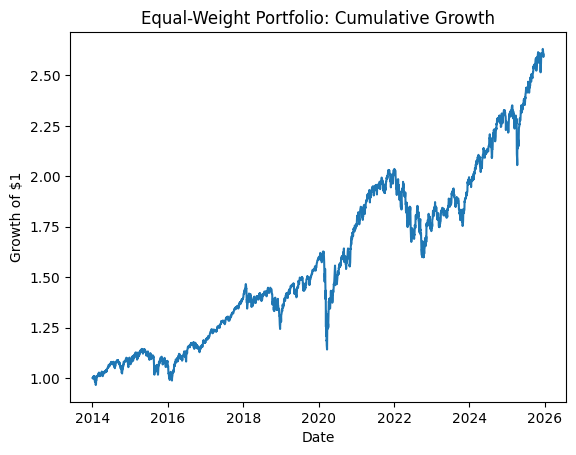

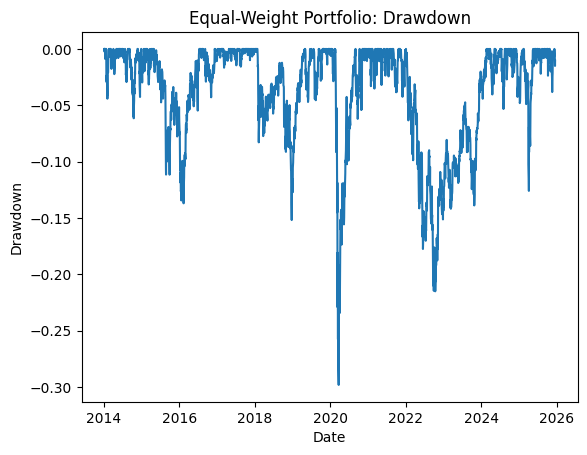

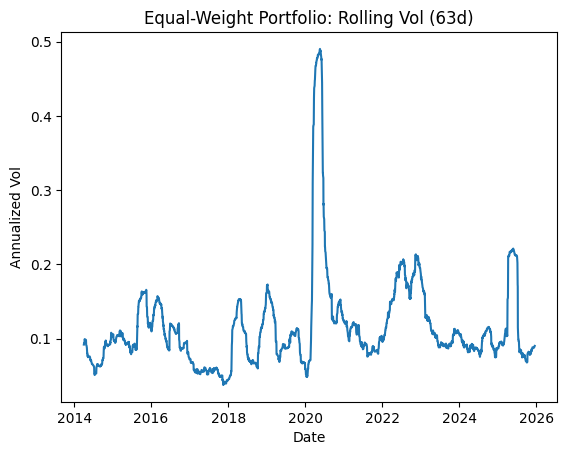

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load returns (log returns)
rets = pd.read_csv("/Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025/data_processed/returns_log.csv", index_col=0, parse_dates=True).sort_index()

print("Return matrix shape (days x ETFs):", rets.shape)
print("Date range:", rets.index.min().date(), "to", rets.index.max().date())

# Monthly rebalance dates = first trading day of each month
rebalance_dates = rets.groupby([rets.index.year, rets.index.month]).head(1).index

tickers = rets.columns
n = len(tickers)

# Equal-weight on rebalance dates
weights = pd.DataFrame(index=rebalance_dates, columns=tickers, data=1.0 / n)

# Daily weights between rebalances
weights_daily = weights.reindex(rets.index).ffill()

# Portfolio daily log returns
port_log_rets = (weights_daily * rets).sum(axis=1)

# Convert log returns to simple returns for plotting/performance stats
port_simple_rets = np.exp(port_log_rets) - 1

# Performance metrics
ann_ret = port_simple_rets.mean() * 252
ann_vol = port_simple_rets.std() * np.sqrt(252)
sharpe = ann_ret / ann_vol

cum = (1 + port_simple_rets).cumprod()
drawdown = cum / cum.cummax() - 1

print(f"\nEqual-Weight (Monthly Rebalance) Metrics:")
print(f"Annualized return: {ann_ret:.3%}")
print(f"Annualized vol:    {ann_vol:.3%}")
print(f"Sharpe (rf=0):     {sharpe:.2f}")
print(f"Max drawdown:      {drawdown.min():.3%}")

# Plots
plt.figure()
plt.plot(cum)
plt.title("Equal-Weight Portfolio: Cumulative Growth")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.show()

plt.figure()
plt.plot(drawdown)
plt.title("Equal-Weight Portfolio: Drawdown")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.show()

plt.figure()
plt.plot(port_simple_rets.rolling(63).std() * np.sqrt(252))
plt.title("Equal-Weight Portfolio: Rolling Vol (63d)")
plt.xlabel("Date")
plt.ylabel("Annualized Vol")
plt.show()
